In [35]:
import torch
from torch import nn
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import torch.optim as optim

/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


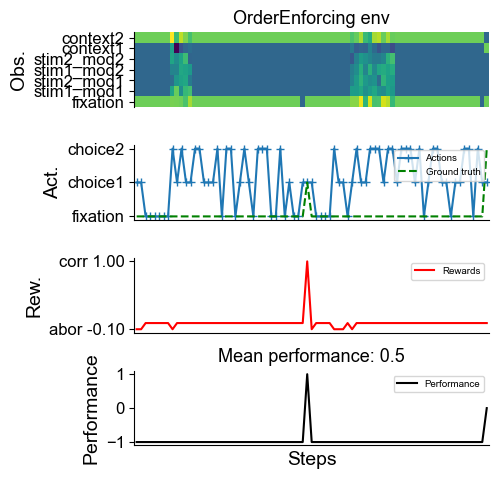

In [36]:

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
# task = 'PerceptualDecisionMaking-v0'
# task = 'GoNogo-v0'
task = 'ContextDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing, 'sigma': 1.0}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [37]:
#Leaky-RNN
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1-self.alpha) + h_new * self.alpha #1st TODO: Implement the leaky integration
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden




In [38]:
class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size,reg_WD=0.01, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)
        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

        self.reg_WD = Reg_WD(reg_WD=reg_WD, neuron_num=hidden_size)
        

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        # rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        # out = self.fc(rnn_e)
        out = self.fc(rnn_output)
        return out, rnn_output
        
    def calculate_regularization_loss(self):
        recurrent_kernel = self.rnn.h2h.weight  # assuming LeakyRNN exposes recurrent_kernel
        return self.reg_WD(recurrent_kernel)

In [39]:
class Reg_WD(torch.nn.Module):

    """A regulariser for spatially embedded RNNs.
  Applies L1 regularisation to recurrent kernel of
  RNN which is weighted by the distance of units
  in predefined 3D space.
  Calculation:
      reg_WD * sum[distance_matrix o recurrent_kernel]
  Attributes:
      reg_WD: Float; Weighting of Reg_WD regularisation term.
      network_structure: Defines a 3D grid specifying the
      dimensions of a 3D space where neurons are placed.
      The tuple specifies the range of coordinates along
      each of the three axes in this 3D space.
  """

    def __init__(self, reg_WD=0.01, neuron_num=100, network_structure=(5,5,2), coordinates_list=None, distance_power=1, distance_metric='euclidean'):
        super(Reg_WD, self).__init__()

        self.distance_power = distance_power
        self.reg_WD = torch.tensor([reg_WD], dtype=torch.float32)

        # Set up tensor with distance matrix
        nx = np.arange(network_structure[0])
        ny = np.arange(network_structure[1])
        nz = np.arange(network_structure[2])

        # Set up coordinate grid
        x, y, z = np.meshgrid(nx, ny, nz)
        self.coordinates = [x.ravel(), y.ravel(), z.ravel()]

        # Override coordinate grid if provided in init
        if coordinates_list is not None:
            self.coordinates = coordinates_list

        # Check neuron number / number of coordinates
        if (len(self.coordinates[0]) == neuron_num) and (len(self.coordinates[1]) == neuron_num) and (len(self.coordinates[2]) == neuron_num):
            pass
        else:
            raise ValueError('Network / coordinate structure does not match the number of neurons.')

        # Calculate the euclidean distance matrix
        euclidean_vector = scipy.spatial.distance.pdist(np.transpose(self.coordinates), metric=distance_metric)
        euclidean = scipy.spatial.distance.squareform(euclidean_vector ** self.distance_power)
        self.distance_matrix = torch.tensor(euclidean, dtype=torch.float32)

    def forward(self, x):
        abs_weight_matrix = torch.abs(x)
        WD_loss = self.reg_WD * torch.sum(abs_weight_matrix * self.distance_matrix)
        return WD_loss

    def _check_penalty_number(self, x):
        if not isinstance(x, (float, int)):
            raise ValueError(('Value: {} is not a valid regularization penalty number, '
                              'expected an int or float value').format(x))

    def visualise_distance_matrix(self):
        plt.imshow(self.distance_matrix.numpy())
        plt.colorbar()
        plt.show()

    def visualise_neuron_structure(self):
        # fig = plt.figure()
        # ax = Axes3D(fig)
        # ax.scatter(self.coordinates[0], self.coordinates[1], self.coordinates[2], c='b', marker='.')
        # ax.set_xlabel('x')
        # ax.set_ylabel('y')
        # ax.set_zlabel('z')
        # plt.show()
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot of neurons in 3D space
        ax.scatter(self.coordinates[0], self.coordinates[1], self.coordinates[2],
                c='b', marker='.', alpha=0.8)

        # Label axes
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title('Neuron Spatial Structure')

        # Show the plot
        plt.show()

    def get_config(self):
        return {'reg_WD': float(self.reg_WD)}


In [43]:

logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
WD_net = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size,reg_wd=0.1, dt=env.dt, sigma_rec=0)
print(WD_net)

# Use Adam optimizer
optimizer = optim.Adam(WD_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 10
loss_reg_values = []
for i in range(7000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = WD_net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss_main = criterion(output, labels)
    loss_reg = WD_net.calculate_regularization_loss()
    
    loss = loss_main + loss_reg


    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        loss_reg_values.append(loss_reg.item())
        running_loss = 0.0

df = pd.DataFrame(loss_values, columns=['Loss'])
df.to_csv('/Users/edatkinson/4th Year/CogAI/Assessment/loss_values_WD.csv', index=False)
dwd = pd.DataFrame(loss_reg_values, columns=['Loss'])
dwd.to_csv('/Users/edatkinson/4th Year/CogAI/Assessment/loss_reg_values_WD.csv', index=False)


# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=7, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
  (reg_WD): Reg_WD()
)
Step 10, Loss 5.2600
Step 20, Loss 4.4861
Step 30, Loss 3.8057
Step 40, Loss 3.1686
Step 50, Loss 2.6341
Step 60, Loss 2.1931
Step 70, Loss 1.7955
Step 80, Loss 1.4479
Step 90, Loss 1.1638
Step 100, Loss 0.8937
Step 110, Loss 0.6927
Step 120, Loss 0.5211
Step 130, Loss 0.4082
Step 140, Loss 0.3362
Step 150, Loss 0.3020
Step 160, Loss 0.2775
Step 170, Loss 0.2659
Step 180, Loss 0.2653
Step 190, Loss 0.2541
Step 200, Loss 0.2509
Step 210, Loss 0.2554
Step 220, Loss 0.2323
Step 230, Loss 0.2330
Step 240, Loss 0.2256
Step 250, Loss 0.2292
Step 260, Loss 0.2172
Step 270, Loss 0.2185
Step 280, Loss 0.2064
Step 290, Loss 0.2035
Step 300, Loss 0.2037
Step 310, Loss 0.1896
Step 320, Loss 0.1943
Step 330, Loss 0.1846
Step 340, Loss 0.1869
Step 350, Loss 0.1882


/opt/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/opt/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


KeyboardInterrupt: 

In [24]:
# @title Run the network post-training and record neural activity
plt.rcParams['axes.labelsize'] = 14  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['axes.titlesize'] = 13  # Title font size
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], [], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = WD_net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]
    print('Trial {}, Correct: {}, Choice: {}, Ground truth: {}'.format(i, correct, choice, gt[-1]))
    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    # print(env.start_ind)
    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    # rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]

    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Trial 0, Correct: True, Choice: 1, Ground truth: 1
Trial 1, Correct: True, Choice: 1, Ground truth: 1
Trial 2, Correct: True, Choice: 2, Ground truth: 2
Trial 3, Correct: True, Choice: 2, Ground truth: 2
Trial 4, Correct: False, Choice: 1, Ground truth: 2
Trial 5, Correct: True, Choice: 1, Ground truth: 1
Trial 6, Correct: True, Choice: 2, Ground truth: 2
Trial 7, Correct: True, Choice: 1, Ground truth: 1
Trial 8, Correct: True, Choice: 1, Ground truth: 1
Trial 9, Correct: True, Choice: 1, Ground truth: 1
Trial 10, Correct: True, Choice: 1, Ground truth: 1
Trial 11, Correct: True, Choice: 1, Ground truth: 1
Trial 12, Correct: True, Choice: 2, Ground truth: 2
Trial 13, Correct: True, Choice: 1, Ground truth: 1
Trial 14, Correct: True, Choice: 2, Ground truth: 2
Trial 15, Correct: True, Choice: 2, Ground truth: 2
Trial 16, Correct: True, Choice: 1, Ground truth: 1
Trial 17, Correct: True, Choice: 2, Ground truth: 2
Trial 18, Correct: True, Choice: 1, Ground truth: 1
Trial 19, Correct: Tr

Confusion Matrix:
[[205  39]
 [ 65 191]]


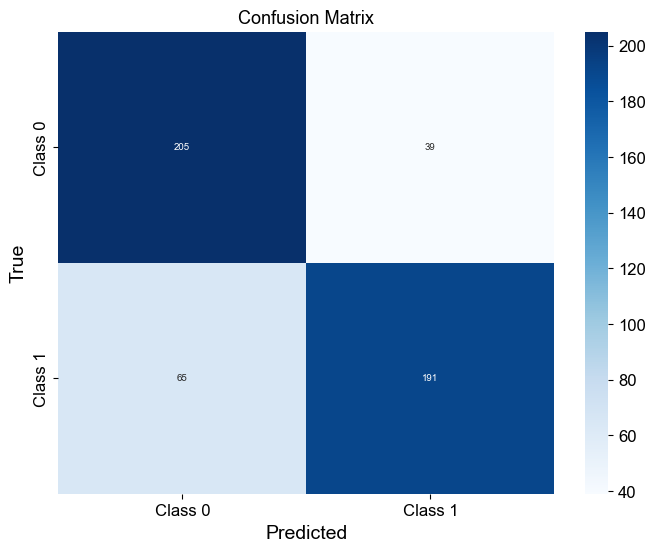

              precision    recall  f1-score   support

     Class 0       0.76      0.84      0.80       244
     Class 1       0.83      0.75      0.79       256

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.80      0.79      0.79       500



In [25]:
all_choices = []
all_ground_truths = []

for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = WD_net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Store predictions and ground truth
    all_choices.append(choice)
    all_ground_truths.append(gt[-1])


from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(all_ground_truths, all_choices)

print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot with class names (e.g., 0 and 1 for binary classification)
plot_confusion_matrix(conf_matrix, class_names=['Class 0', 'Class 1'])

from sklearn.metrics import classification_report

print(classification_report(all_ground_truths, all_choices, target_names=['Class 0', 'Class 1']))

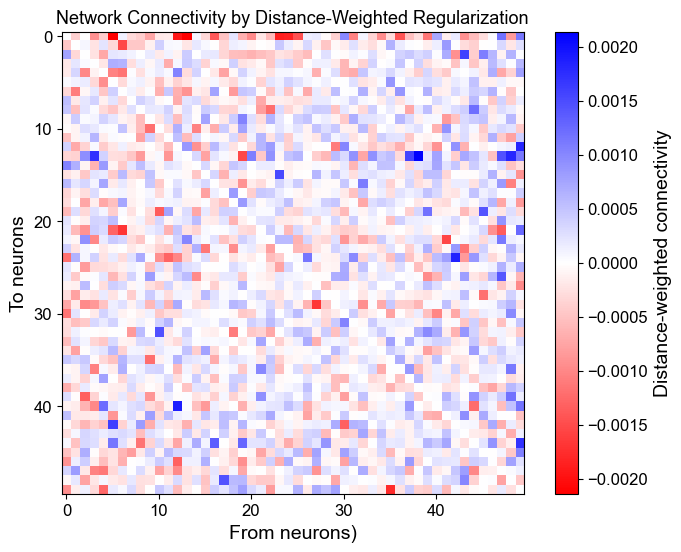

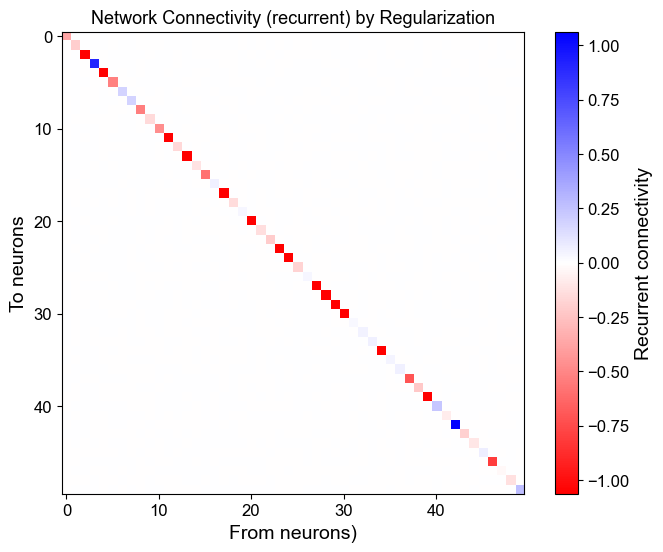

In [26]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt
import numpy as np

# Extract the recurrent kernel weights and distance matrix
recurrent_kernel = WD_net.rnn.h2h.weight.detach().numpy()  # Assuming the network is trained
distance_matrix = WD_net.reg_WD.distance_matrix.numpy()  # Get the distance matrix from the regularizer

# Calculate distance-weighted connectivity
distance_weighted_connectivity = recurrent_kernel * distance_matrix

# Sort neurons by their average distance-weighted connectivity
average_connectivity = np.mean(distance_weighted_connectivity, axis=0)
sort_indices = np.argsort(average_connectivity)

# Reorder the weights for visualization
sorted_connectivity = distance_weighted_connectivity[sort_indices, :][:, sort_indices]

# Plot the connectivity matrix
plt.figure(figsize=(8, 6))
plt.imshow(sorted_connectivity, cmap='bwr_r', vmin=-np.max(sorted_connectivity), vmax=np.max(sorted_connectivity))
plt.colorbar(label='Distance-weighted connectivity')
plt.title('Network Connectivity by Distance-Weighted Regularization')
plt.xlabel('From neurons)')
plt.ylabel('To neurons')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(recurrent_kernel, cmap='bwr_r', vmin=-np.max(recurrent_kernel), vmax=np.max(recurrent_kernel))
plt.colorbar(label='Recurrent connectivity')
plt.title('Network Connectivity (recurrent) by Regularization')
plt.xlabel('From neurons)')
plt.ylabel('To neurons')
plt.show()



# Neurons closer together have stronger connections



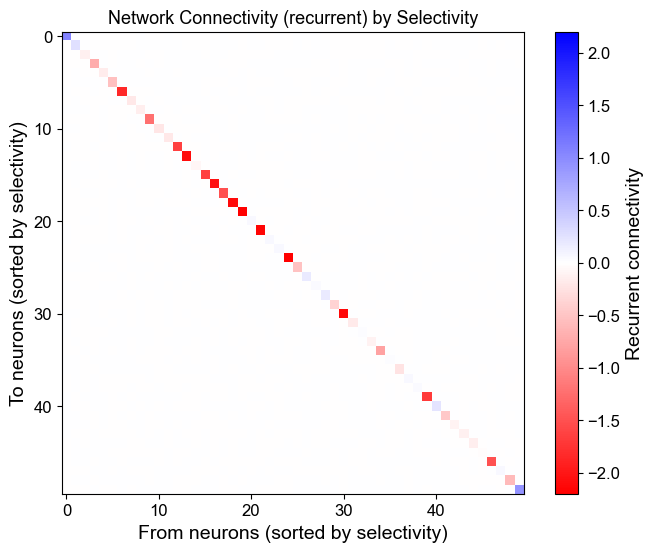

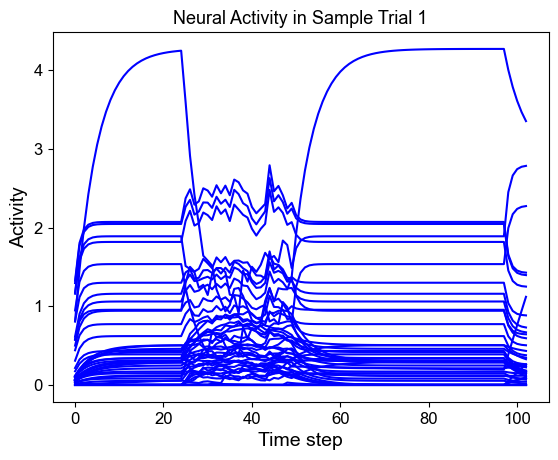

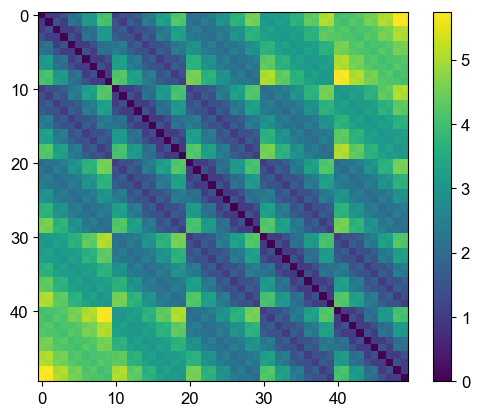

In [27]:
# Extract the recurrent kernel weights and distance matrix
recurrent_kernel = WD_net.rnn.h2h.weight.detach().numpy()  # Assuming the network is traine
distance_matrix = WD_net.reg_WD.distance_matrix.numpy()  # Get the distance matrix from the regularizer

distance_weighted_connectivity = recurrent_kernel * distance_matrix
#
# Compute stimulus selectivity (d') for sorting neurons
mean_activity = []
std_activity = []
for ground_truth in [1,2]:  # Assuming stim_activity contains data for ground_truth = 0, 1
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))  # Mean activity during stimulus
    std_activity.append(np.std(activity, axis=0))   # Standard deviation during stimulus

# Compute selectivity (d')
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort neurons by stimulus selectivity
selectivity_sort_indices = np.argsort(selectivity)  # Sort by selectivity
sorted_connectivity_by_selectivity = distance_weighted_connectivity[selectivity_sort_indices, :][:, selectivity_sort_indices]

# Plot the raw recurrent connectivity matrix sorted by selectivity
sorted_recurrent_kernel = recurrent_kernel[selectivity_sort_indices, :][:, selectivity_sort_indices]
wlim = np.max(np.abs(sorted_recurrent_kernel))
plt.figure(figsize=(8, 6))
plt.imshow(sorted_recurrent_kernel, cmap='bwr_r',
           vmin=-wlim,
           vmax=wlim)
plt.colorbar(label='Recurrent connectivity')
plt.title('Network Connectivity (recurrent) by Selectivity')
plt.xlabel('From neurons (sorted by selectivity)')
plt.ylabel('To neurons (sorted by selectivity)')
plt.show()
trial = 1

plt.figure()
_ = plt.plot(activity_dict[trial][:, :], color='blue')
plt.xlabel('Time step')
plt.ylabel('Activity')
plt.title('Neural Activity in Sample Trial 1')
plt.show()

WD_net.reg_WD.visualise_distance_matrix()



In [28]:
%cd fixed-point-finder
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

[Errno 2] No such file or directory: 'fixed-point-finder'
/Users/edatkinson/4th Year/CogAI/Assessment/fixed-point-finder


In [29]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # Leaky-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your Leaky-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

In [30]:
# Instantiate the FixedPointRNNWrapper with the Leaky-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(WD_net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, WD_net.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, WD_net.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

print('Initial hidden states shape:', init_hidden_np.shape)
print('Inputs shape:', inputs_np.shape)

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

Initial hidden states shape: (10, 50)
Inputs shape: (10, 7)

Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		285 iters
		q = 6.44e-13 +/- 2.09e-13
		dq = 1.67e-13 +/- 1.58e-13
		learning rate = 5.99e-01
		avg iter time = 2.13e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



Shape of the neural activity (Time points, Neurons): (48443, 50)
Shape of the projected activity (Time points, PCs): (48443, 2)


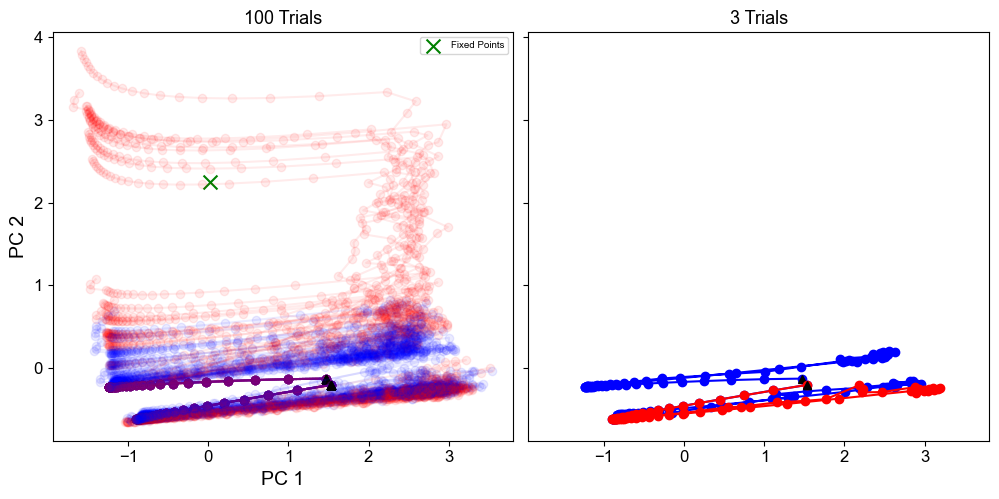

In [31]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse
plot_until_time = 70

# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 2 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color, alpha=0.08)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
        ax2.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')
    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]
# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)
ax1.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='green', marker='x', s=100, label='Fixed Points')
# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
ax1.legend(loc='upper right')
plt.tight_layout()
plt.show()

# for i in range(20):  # Fewer trials for clarity
#     activity_pc_trial = pca.transform(activity_dict[i])  # Project activity for each trial
#     # Color by ground truth
#     trial = trial_infos[i]
#     color = 'red' if trial['ground_truth'] == 0 else 'blue'

#     plt.plot(range(55), activity_pc_trial[:plot_until_time, 0], color=color, label=f'Trial {i+1}', alpha=0.5)
#     plt.xlabel('Time Step')
#     plt.ylabel('PC 1')
#     plt.title('Temporal Dynamics in PC Space')
#     # ax4.legend(loc='upper left')

# # Final adjustments
# plt.tight_layout()
# plt.show()


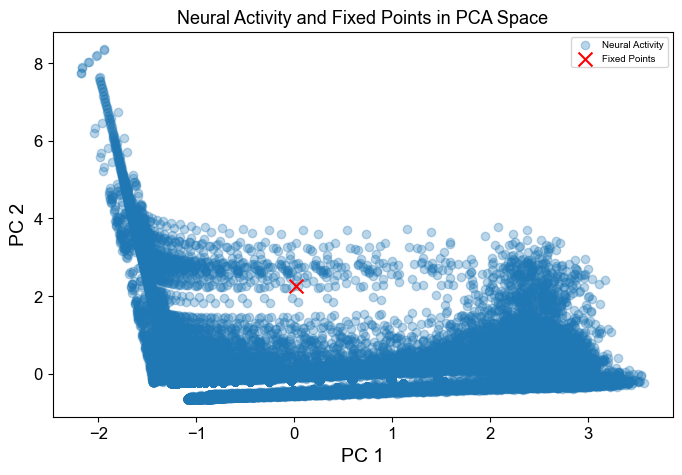

In [32]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space")
plt.legend()
plt.show()



Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		255 iters
		q = 8.25e-13 +/- 6.40e-14
		dq = 2.53e-13 +/- 2.22e-13
		learning rate = 2.26e-01
		avg iter time = 2.57e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		263 iters
		q = 6.39e-13 +/- 6.81e-14
		dq = 1.26e-12 +/- 7.80e-14
		learning r

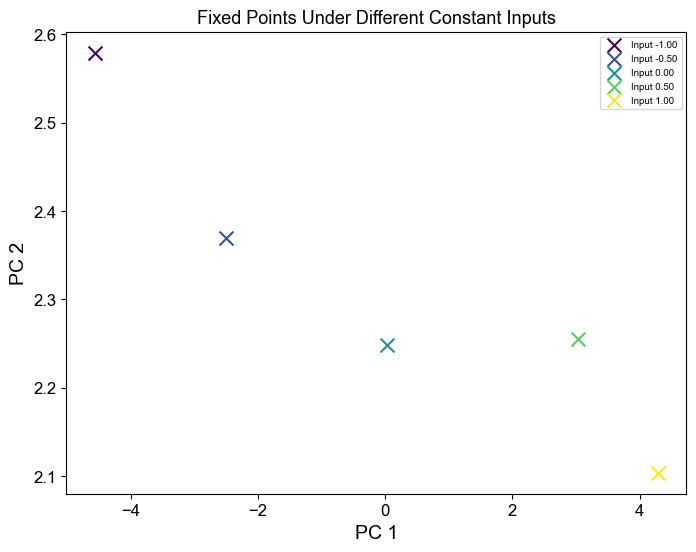

In [33]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input = []

for input_val in input_values:
    # Prepare constant input
    inputs_np = np.full((10, WD_net.rnn.input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np = initial_conditions.cpu().numpy()

    # Find fixed points with the current input
    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    # Project fixed points into PCA space
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()


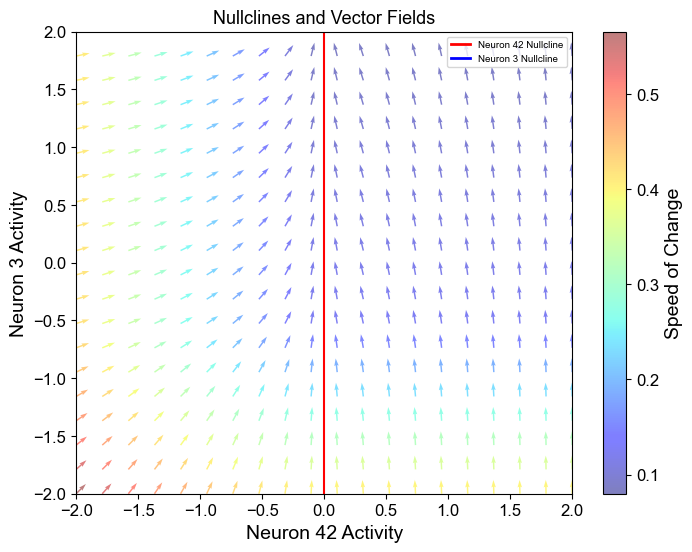

In [34]:
from matplotlib.lines import Line2D
# Select two neurons with highest selectivity
selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

# Define ranges for the two neurons
n_points = 20
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

# Flatten the grids
grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

# Prepare inputs (constant zero input)
inputs = torch.zeros(grid_states.shape[0], WD_net.rnn.input_size).type(torch.float32)

# Prepare initial states for all neurons, keeping other neurons at zero
initial_states = np.zeros((grid_states.shape[0], WD_net.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]

# Convert to torch tensors
initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)

# Run one step of the RNN
_, next_states = WD_net.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()

# Compute derivatives for the two neurons
d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]

# Reshape to grid
d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)

# Compute vector field
U = d_neuron1_grid  # Change in neuron1
V = d_neuron2_grid  # Change in neuron2

# Normalize the vector field for better visualization
speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed

# Plot nullclines and vector field
plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)

# legend entries
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
                   Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.xlabel(f'Neuron {neuron1} Activity')
plt.ylabel(f'Neuron {neuron2} Activity')
plt.title('Nullclines and Vector Fields')
plt.colorbar(label='Speed of Change')
plt.show()
